# Instacart Analysis
## 0. Setup & Sanity Checks

In [6]:
# --- setup to save figures ---
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parent
FIGS = PROJECT_ROOT / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)  # crea la carpeta si no existe
print("Saving figures to:", FIGS)

Saving figures to: /Users/dannychacon/Documents/Proyectos/port-sql-project/reports/figures


In [7]:
# --- make project root importable from a notebook ---
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))
# ----------------------------------------------------

import pandas as pd
from src.db import sqlite_engine
engine, _ = sqlite_engine("instacart.db")

In [3]:
queries = [
    ("orders", "SELECT COUNT(*) AS n FROM orders;"),
    ("products", "SELECT COUNT(*) AS n FROM products;"),
    ("aisles", "SELECT COUNT(*) AS n FROM aisles;"),
    ("departments", "SELECT COUNT(*) AS n FROM departments;"),
    ("order_products_prior", "SELECT COUNT(*) AS n FROM order_products_prior;"),
    ("order_products_train", "SELECT COUNT(*) AS n FROM order_products_train;"),
]
for name, q in queries:
    print(name)
    display(pd.read_sql(q, engine))

orders


,n
0,3421083


products


,n
0,49688


aisles


,n
0,134


departments


,n
0,21


order_products_prior


,n
0,32434489


order_products_train


,n
0,1384617


In [4]:
pd.read_sql("""
SELECT
  SUM(CASE WHEN department_id IS NULL THEN 1 ELSE 0 END) AS products_null_department,
  SUM(CASE WHEN aisle_id IS NULL THEN 1 ELSE 0 END) AS products_null_aisle
FROM products;
""", engine)

,products_null_department,products_null_aisle
0,0,0


In [6]:
pd.read_sql("""
SELECT d.department,
       COUNT(p.product_id) AS n_products
FROM products p
JOIN departments d ON d.department_id = p.department_id
GROUP BY d.department
ORDER BY n_products DESC
LIMIT 10;
""", engine)

,department,n_products
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007
5,dairy eggs,3449
6,household,3085
7,canned goods,2092
8,dry goods pasta,1858
9,produce,1684


## 1. Exploratory Queries – Business Basics

### Query 1 – Total Orders & Unique Users

In [5]:
pd.read_sql("""
SELECT 
    COUNT(DISTINCT order_id) AS n_orders,
    COUNT(DISTINCT user_id) AS n_users
FROM orders;
""", engine)

,n_orders,n_users
0,3421083,206209


### Query 2 – Orders by Day of Week

In [6]:
pd.read_sql("""
SELECT order_dow, COUNT(*) AS n_orders
FROM orders
GROUP BY order_dow
ORDER BY order_dow;
""", engine)

,order_dow,n_orders
0,0,600905
1,1,587478
2,2,467260
3,3,436972
4,4,426339
5,5,453368
6,6,448761


Matplotlib is building the font cache; this may take a moment.


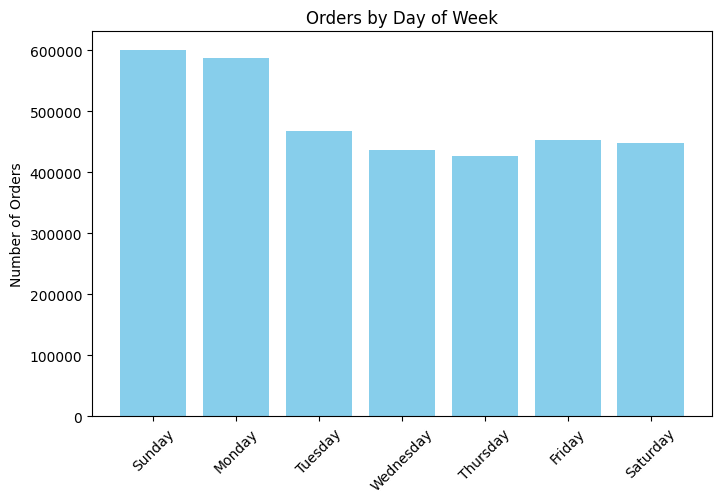

In [ ]:
import matplotlib.pyplot as plt

# Bring data with SQL
df_dow = pd.read_sql("""
SELECT order_dow, COUNT(*) AS n_orders
FROM orders
GROUP BY order_dow
ORDER BY order_dow;
""", engine)

# Maping days (0=Sunday, 6=Saturday)
days = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
df_dow["day_name"] = df_dow["order_dow"].map({i:day for i,day in enumerate(days)})

# Grap
plt.figure(figsize=(8,5))
plt.bar(df_dow["day_name"], df_dow["n_orders"], color="skyblue")
plt.title("Orders by Day of Week")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()

### Query 3 – Orders by Hour of Day

In [7]:
pd.read_sql("""
SELECT order_hour_of_day, COUNT(*) AS n_orders
FROM orders
GROUP BY order_hour_of_day
ORDER BY order_hour_of_day;
""", engine)

,order_hour_of_day,n_orders
0,0,22758
1,1,12398
2,2,7539
3,3,5474
4,4,5527
5,5,9569
6,6,30529
7,7,91868
8,8,178201
9,9,257812


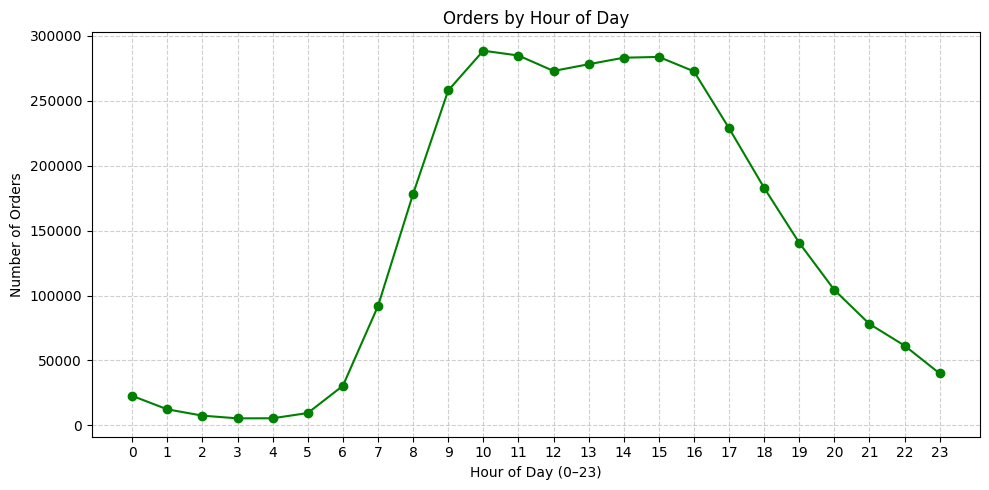

In [ ]:
# Bring data with SQL
df_hour = pd.read_sql("""
SELECT order_hour_of_day, COUNT(*) AS n_orders
FROM orders
GROUP BY order_hour_of_day
ORDER BY order_hour_of_day;
""", engine)

# Grap – Orders by Hour of Day
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_hour["order_hour_of_day"], df_hour["n_orders"], marker="o", color="green")
ax.set_title("Orders by Hour of Day")
ax.set_xlabel("Hour of Day (0–23)")
ax.set_ylabel("Number of Orders")
ax.set_xticks(range(0,24))
ax.grid(True, linestyle="--", alpha=0.6)

# Save before showing
fig.tight_layout()
fig.savefig(FIGS / "orders_by_hour.png", dpi=220, bbox_inches="tight")
plt.show()


### Query 4 – Top 10 Most Purchased Products
We want to identify which products are bought most frequently across all orders.  
This helps the business understand product popularity and manage inventory accordingly.

In [10]:
pd.read_sql("""
SELECT p.product_name,
       COUNT(op.product_id) AS n_purchases
FROM order_products_prior op
JOIN products p ON p.product_id = op.product_id
GROUP BY p.product_name
ORDER BY n_purchases DESC
LIMIT 10;
""", engine)

,product_name,n_purchases
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


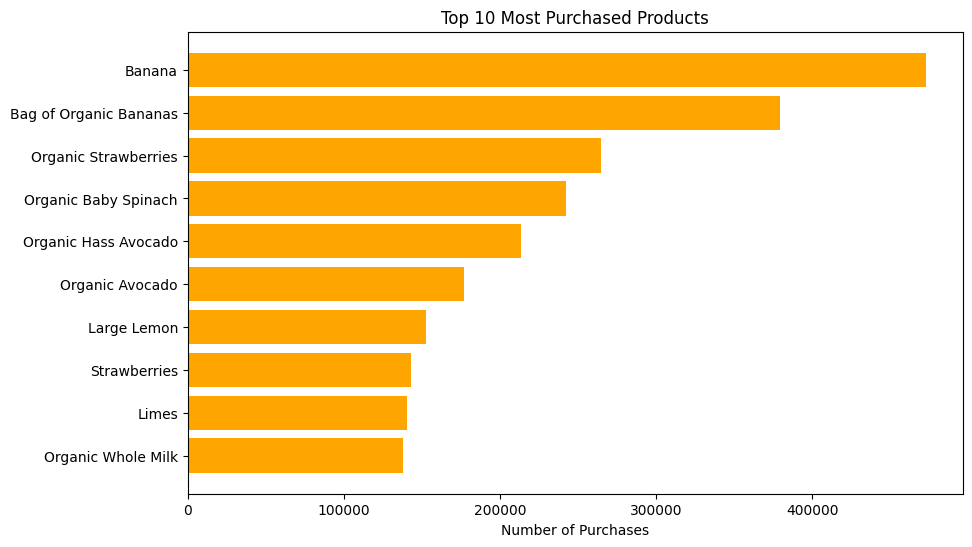

In [ ]:
# Query in dataframe
df_top_products = pd.read_sql("""
SELECT p.product_name,
       COUNT(op.product_id) AS n_purchases
FROM order_products_prior op
JOIN products p ON p.product_id = op.product_id
GROUP BY p.product_name
ORDER BY n_purchases DESC
LIMIT 10;
""", engine)

# Graph – Top 10 Most Purchased Products
plt.figure(figsize=(10,6))
plt.barh(df_top_products["product_name"], df_top_products["n_purchases"], color="orange")
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Number of Purchases")
plt.gca().invert_yaxis()  # para que el top 1 quede arriba
plt.show()

### Query 5 – Top Departments by Purchase Volume
To get a higher-level view of customer preferences, we analyze purchases grouped by department.  
This tells us which product categories generate the most demand.

In [11]:
pd.read_sql("""
SELECT d.department,
       COUNT(op.product_id) AS n_purchases
FROM order_products_prior op
JOIN products p ON p.product_id = op.product_id
JOIN departments d ON d.department_id = p.department_id
GROUP BY d.department
ORDER BY n_purchases DESC
LIMIT 10;
""", engine)

,department,n_purchases
0,produce,9479291
1,dairy eggs,5414016
2,snacks,2887550
3,beverages,2690129
4,frozen,2236432
5,pantry,1875577
6,bakery,1176787
7,canned goods,1068058
8,deli,1051249
9,dry goods pasta,866627


/var/folders/rp/npvgzw7d46s82_ph0ggm655r0000gn/T/ipykernel_34127/3108920438.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_top_departments["department"], rotation=45, ha="right")


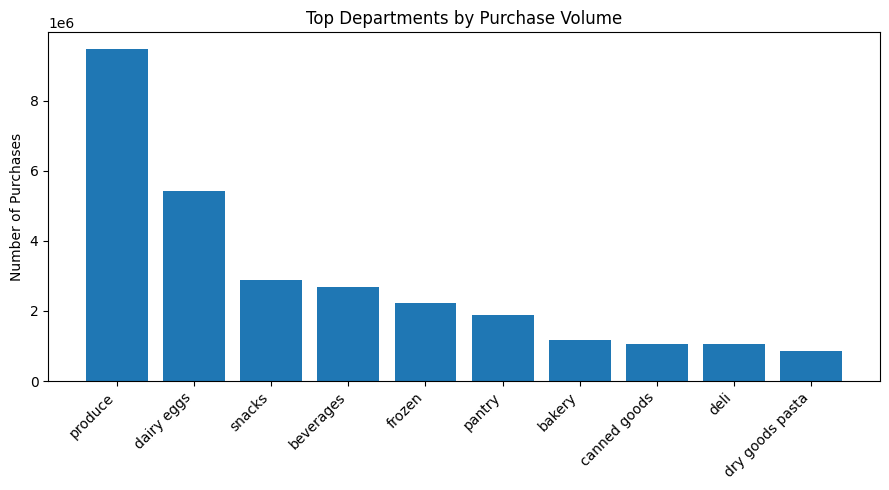

In [ ]:
# Query in dataframe
df_top_departments = pd.read_sql("""
SELECT d.department,
       COUNT(op.product_id) AS n_purchases
FROM order_products_prior op
JOIN products p ON p.product_id = op.product_id
JOIN departments d ON d.department_id = p.department_id
GROUP BY d.department
ORDER BY n_purchases DESC
LIMIT 10;
""", engine)

# Grap and export
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(df_top_departments["department"], df_top_departments["n_purchases"])
ax.set_title("Top Departments by Purchase Volume")
ax.set_ylabel("Number of Purchases")
ax.set_xticklabels(df_top_departments["department"], rotation=45, ha="right")

fig.tight_layout()
fig.savefig(FIGS / "top_departments.png", dpi=220, bbox_inches="tight")
plt.show()

### Query 6 – Average Number of Products per Order
We want to calculate the average basket size (how many products each order contains).  
This metric is useful for logistics and marketing, since it helps estimate revenue per order and customer buying patterns.

In [14]:
pd.read_sql("""
SELECT AVG(n_products) AS avg_products_per_order
FROM (
    SELECT order_id, COUNT(*) AS n_products
    FROM order_products_prior
    GROUP BY order_id
);
""", engine)

,avg_products_per_order
0,10.088883


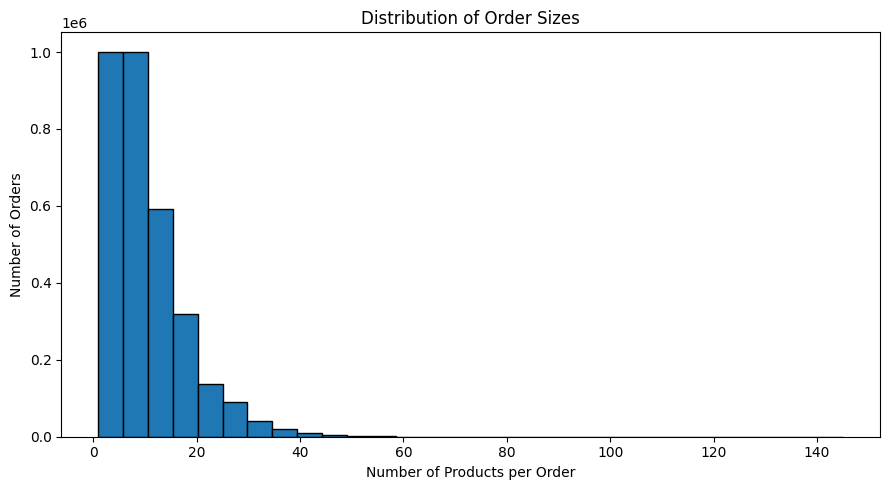

In [ ]:
df_order_size = pd.read_sql("""
SELECT order_id, COUNT(*) AS n_products
FROM order_products_prior
GROUP BY order_id;
""", engine)

# Grap and export
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(df_order_size["n_products"], bins=30, edgecolor="black")
ax.set_title("Distribution of Order Sizes")
ax.set_xlabel("Number of Products per Order")
ax.set_ylabel("Number of Orders")

fig.tight_layout()
fig.savefig(FIGS / "basket_size_hist.png", dpi=220, bbox_inches="tight")
plt.show()

### Query 7 – Reorder Rate
We analyze how many products are purchased again (`reordered = 1`).  
This shows customer loyalty to specific products and helps identify anchor products that drive repeat sales.

In [16]:
pd.read_sql("""
SELECT 
    SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS reorder_rate
FROM order_products_prior;
""", engine)

,reorder_rate
0,0.589697


### Query 8 – Distribution of Orders per User
We calculate how many orders each user has placed.  
This shows the overall distribution of customer activity (one-time vs repeat customers).

In [18]:
df_orders_per_user = pd.read_sql("""
SELECT user_id, COUNT(*) AS n_orders
FROM orders
GROUP BY user_id;
""", engine)

df_orders_per_user.head()

,user_id,n_orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


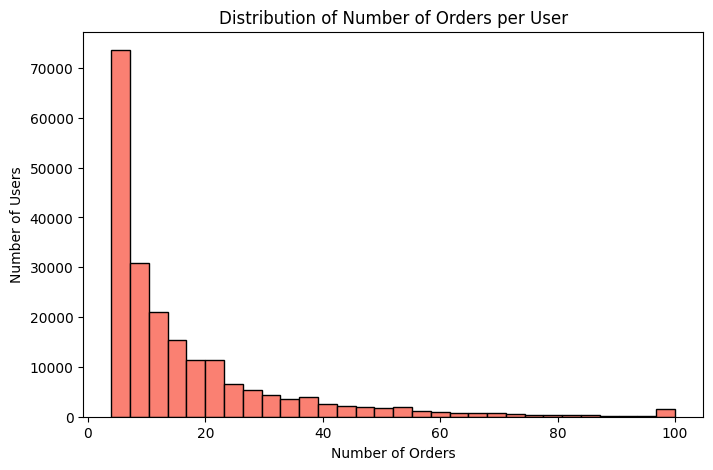

In [19]:
plt.figure(figsize=(8,5))
plt.hist(df_orders_per_user["n_orders"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of Number of Orders per User")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Users")
plt.show()

### Query 9 – Average Days Between Orders
We analyze the column `days_since_prior_order` from the orders table to estimate purchase recency.

In [20]:
pd.read_sql("""
SELECT 
    AVG(days_since_prior_order) AS avg_days_between_orders,
    MIN(days_since_prior_order) AS min_days,
    MAX(days_since_prior_order) AS max_days
FROM orders
WHERE days_since_prior_order IS NOT NULL;
""", engine)

,avg_days_between_orders,min_days,max_days
0,11.114836,0.0,30.0


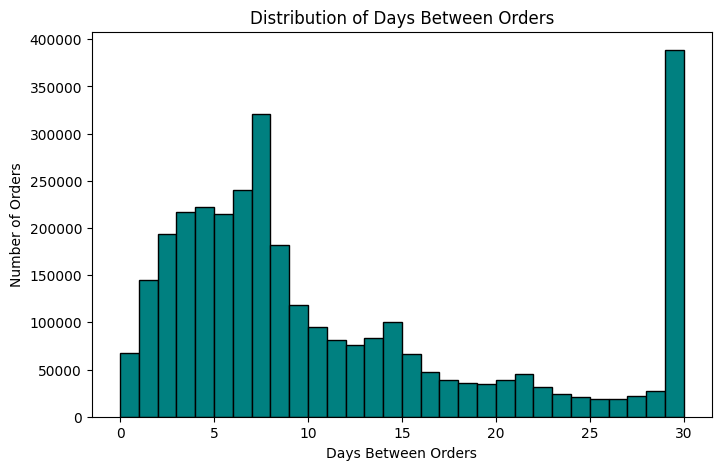

In [21]:
df_days = pd.read_sql("""
SELECT days_since_prior_order
FROM orders
WHERE days_since_prior_order IS NOT NULL;
""", engine)

plt.figure(figsize=(8,5))
plt.hist(df_days["days_since_prior_order"], bins=30, color="teal", edgecolor="black")
plt.title("Distribution of Days Between Orders")
plt.xlabel("Days Between Orders")
plt.ylabel("Number of Orders")
plt.show()

### Query 10 – Orders Heatmap by Day and Hour
We want to understand at which combinations of day and hour customers place the most orders.  
This analysis helps the business optimize staffing, promotions, and logistics operations.

In [9]:
df_heat = pd.read_sql("""
SELECT order_dow, order_hour_of_day, COUNT(*) AS n_orders
FROM orders
GROUP BY order_dow, order_hour_of_day
ORDER BY order_dow, order_hour_of_day;
""", engine)

df_heat.head()

,order_dow,order_hour_of_day,n_orders
0,0,0,3936
1,0,1,2398
2,0,2,1409
3,0,3,963
4,0,4,813


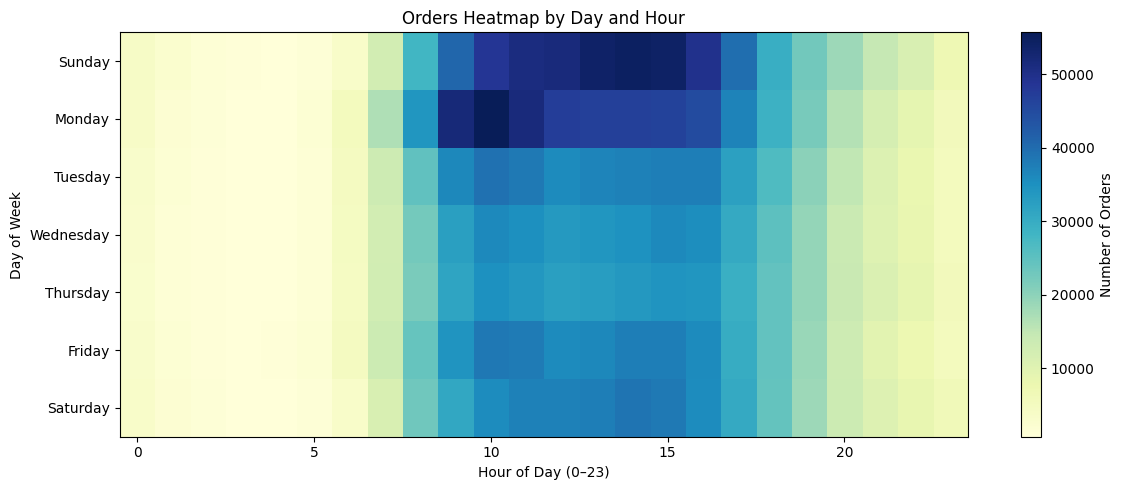

In [ ]:
import matplotlib.pyplot as plt

# Pivot 
days = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
pivot = (df_heat
         .pivot(index="order_dow", columns="order_hour_of_day", values="n_orders")
         .reindex(index=range(7)))  # asegurar 0–6

# 3) Heatmap + Export
fig, ax = plt.subplots(figsize=(12,5))
im = ax.imshow(pivot, aspect="auto", cmap="YlGnBu")

ax.set_title("Orders Heatmap by Day and Hour")
ax.set_xlabel("Hour of Day (0–23)")
ax.set_ylabel("Day of Week")
ax.set_yticks(range(7))
ax.set_yticklabels(days)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Number of Orders")

fig.tight_layout()
# Save before showing
fig.savefig(FIGS / "orders_heatmap.png", dpi=220, bbox_inches="tight")
plt.show()



### Query 11 – Top Products by Reorder Rate (Support ≥ 50k)
We want to identify which products have the highest reorder rate (percentage of times they were reordered),  
but only considering products with a large number of purchases (≥ 50,000).  
This helps the business focus on “anchor products” that customers buy repeatedly.

In [24]:
df_reorder = pd.read_sql("""
SELECT 
  p.product_name,
  COUNT(*) AS total_purchases,
  SUM(CASE WHEN op.reordered = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS reorder_rate
FROM order_products_prior op
JOIN products p ON p.product_id = op.product_id
GROUP BY p.product_name
HAVING COUNT(*) >= 50000
ORDER BY reorder_rate DESC
LIMIT 10;
""", engine)

df_reorder

,product_name,total_purchases,reorder_rate
0,Banana,472565,0.843501
1,Bag of Organic Bananas,379450,0.832555
2,Organic Whole Milk,137905,0.830354
3,Spring Water,56087,0.812274
4,Organic Hass Avocado,213584,0.796553
5,Organic Half & Half,76360,0.781456
6,Organic Strawberries,264683,0.777704
7,Organic Baby Spinach,241921,0.772500
8,Sparkling Water Grapefruit,75886,0.771064
9,Organic Raspberries,137057,0.769089


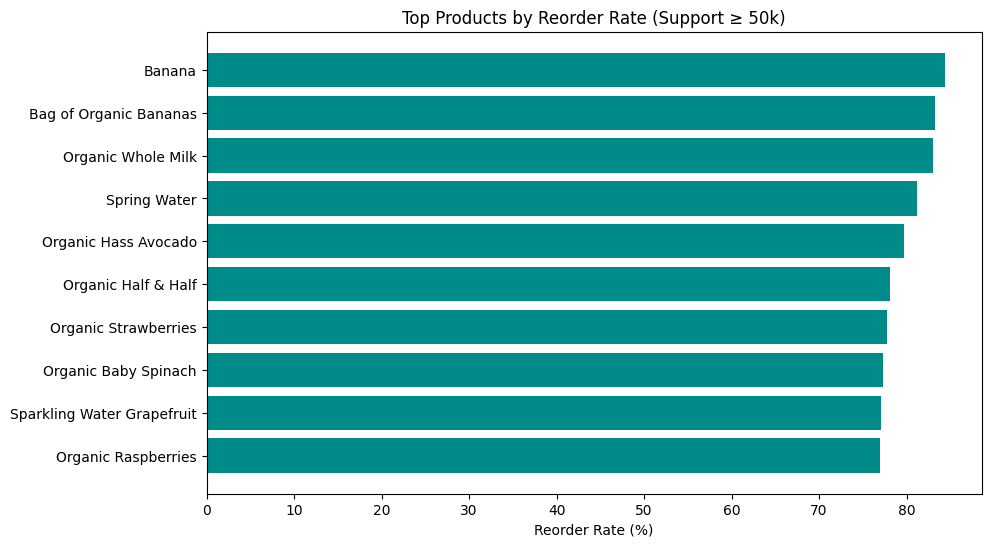

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(df_reorder["product_name"], df_reorder["reorder_rate"]*100, color="darkcyan")
plt.title("Top Products by Reorder Rate (Support ≥ 50k)")
plt.xlabel("Reorder Rate (%)")
plt.gca().invert_yaxis()  # Top product at the top
plt.show()

### Query 12 – Users Segmentation by Number of Orders
We want to segment customers into buckets based on how many orders they placed.  
This allows the business to identify one-time users vs. loyal/repeat customers,  
useful for CRM and targeted marketing campaigns.

In [26]:
df_buckets = pd.read_sql("""
WITH user_orders AS (
  SELECT user_id, COUNT(*) AS n_orders
  FROM orders
  GROUP BY user_id
)
SELECT 
  CASE
    WHEN n_orders = 1                  THEN '1'
    WHEN n_orders BETWEEN 2 AND 5      THEN '2-5'
    WHEN n_orders BETWEEN 6 AND 10     THEN '6-10'
    WHEN n_orders BETWEEN 11 AND 20    THEN '11-20'
    ELSE '>20'
  END AS orders_bucket,
  COUNT(*) AS n_users
FROM user_orders
GROUP BY orders_bucket
ORDER BY CASE orders_bucket
           WHEN '1' THEN 1
           WHEN '2-5' THEN 2
           WHEN '6-10' THEN 3
           WHEN '11-20' THEN 4
           ELSE 5
         END;
""", engine)

df_buckets

,orders_bucket,n_users
0,2-5,43576
1,6-10,60937
2,11-20,50965
3,>20,50731


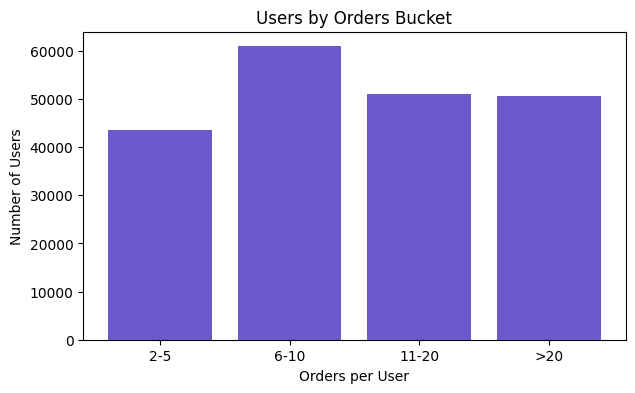

In [27]:
plt.figure(figsize=(7,4))
plt.bar(df_buckets["orders_bucket"], df_buckets["n_users"], color="slateblue")
plt.title("Users by Orders Bucket")
plt.xlabel("Orders per User")
plt.ylabel("Number of Users")
plt.show()

# Business Storytelling – Instacart Sales & Customer Analysis

Based on the analysis of over 3 million Instacart grocery orders, we highlight the following key insights and business recommendations:

---

### 1. Demand Patterns
- **Most orders occur between 10 a.m. and 3 p.m.**, with a sharp increase starting at 8 a.m. and a gradual decline after 8 p.m.  
- **Sundays and Mondays** are the most popular shopping days, while mid-week demand decreases.  
👉 *Recommendation: Allocate logistics and customer support resources during peak hours and consider promotional campaigns mid-week to balance demand.*

---

### 2. Product & Department Insights
- **Produce (fresh fruits and vegetables)** dominates sales with nearly 9 million purchases, followed by Dairy & Eggs, Snacks, and Beverages.  
- Popular individual products include staples such as **bananas, bagged spinach, and whole milk**.  
👉 *Recommendation: Prioritize stock availability and supply chain efficiency in these high-volume categories to sustain customer loyalty.*

---

### 3. Basket Size & Customer Behavior
- The **average order contains ~10 products**, though most baskets fall between 5–15 items.  
- Customer segmentation shows that a large portion of users are **one-time shoppers**, but a significant base makes **6+ repeat purchases**, highlighting opportunities for retention programs.  
👉 *Recommendation: Design personalized offers for repeat customers while implementing onboarding campaigns to convert one-time buyers into loyal customers.*

---

### 4. Reorder Dynamics (Customer Loyalty)
- Approximately **58% of products purchased are reorders**, showing strong loyalty to familiar items.  
- Top reordered products (with high support) include everyday essentials, suggesting that Instacart serves as a primary channel for routine grocery shopping.  
👉 *Recommendation: Leverage these anchor products in cross-selling strategies (e.g., bundle bananas with related breakfast items).*

---

## Final Takeaway
Instacart’s sales data reveals clear patterns in **when customers shop, what they buy, and how loyal they are to specific products**.  
Focusing on peak-hour operations, ensuring availability of high-demand categories, and developing strategies to increase customer retention could directly improve revenue and customer satisfaction.